In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import random

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as k

from tensorflow.keras.datasets import mnist
from tensorflow.python.client import device_lib

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True) 

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.1


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


In [6]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 992326590123785217
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5750390784
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8692795190825922909
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

In [10]:
seed_val = 43

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(seed_val)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(seed_val)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(seed_val)

## Dataset: MNIST

- MNIST dataset, 70000 images total
- 60000 training images
- 10000 test images


In [11]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [12]:
print('x_train:\t{}'.format(train_images.shape))
print('y_train:\t{}'.format(train_labels.shape))
print('x_test:\t\t{}'.format(test_images.shape))
print('y_test:\t\t{}'.format(test_labels.shape))

x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


In [13]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

### Validation Dataset

- Create validation set from training set: 5000 images

In [14]:
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

### Training dataset: distribution

In [314]:
(train_images_dist, train_labels_dist), (test_images_dist, test_labels_dist) = mnist.load_data()

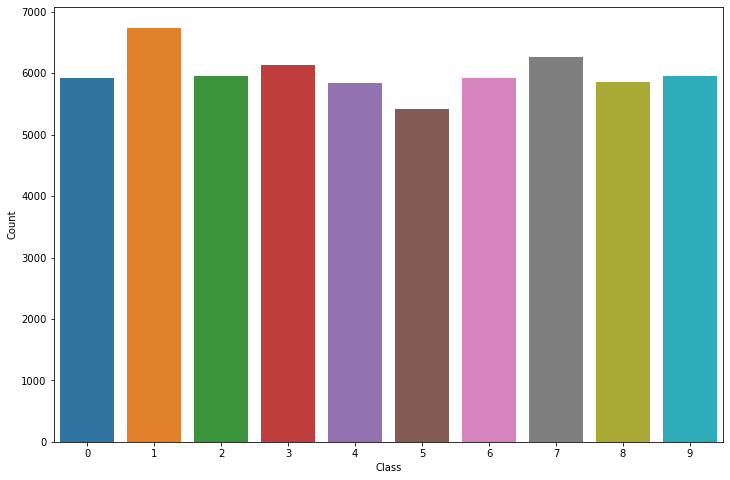

In [315]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(train_labels_dist).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [320]:
train_images_dist

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [321]:
train_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Training dataset: sample images

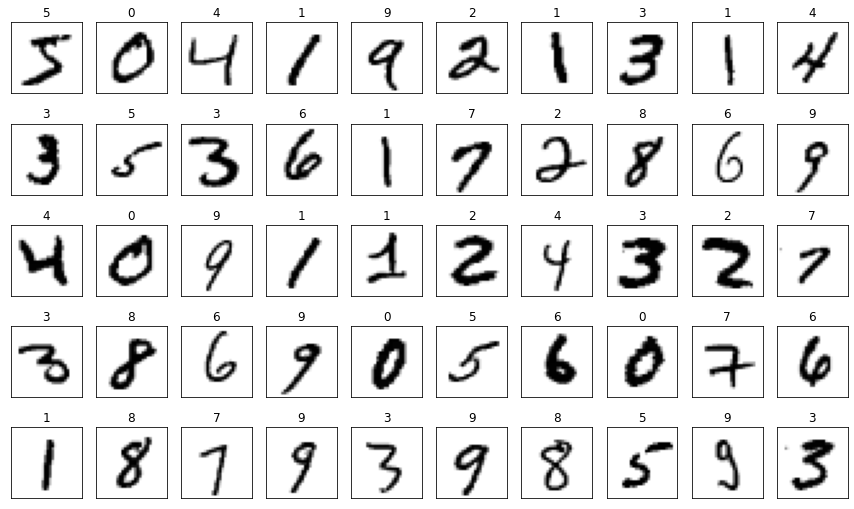

In [318]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(train_labels_dist[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images_dist[i].reshape(28,28), cmap='binary')

In [332]:
np.set_printoptions(linewidth=np.inf)
print("{}".format(train_images_dist[30000]))


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  47 156 205 254 255 112   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  53 208 245 253 253 253 240 249  50   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1  73 242 248 212 128  56  56 122 253  94   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 101 253 211  64   0   0   0   0  66 253 212   0   0   

## Experiment 1

- 784 Input Nodes
- hidden layer: 1 node
- output layer: 10 nodes


In [15]:
# k.clear_session()
model = Sequential([
    Dense(name = 'hidden_layer_1', units=1, activation='relu', input_shape=[784]),
    Dense(name = 'output_layer', units = 10, activation ='softmax')
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 1)                 785       
                                                                 
 output_layer (Dense)        (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='rmsprop',
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])


In [18]:
history = model.fit( train_images
    , train_labels
    , epochs=30
    , validation_data=(val_images, val_labels)
    , callbacks=[tf.keras.callbacks.ModelCheckpoint("exp_1_optimized.h5",save_best_only=True,save_weights_only=False)] 
    )

Epoch 1/30
1719/1719 [==============================] - 8s 4ms/step - loss: 1.9857 - accuracy: 0.2242 - val_loss: 1.8479 - val_accuracy: 0.2762
Epoch 2/30
1719/1719 [==============================] - 8s 5ms/step - loss: 1.8125 - accuracy: 0.3019 - val_loss: 1.7504 - val_accuracy: 0.3338
Epoch 3/30
1719/1719 [==============================] - 7s 4ms/step - loss: 1.7361 - accuracy: 0.3335 - val_loss: 1.6854 - val_accuracy: 0.3618
Epoch 4/30
1719/1719 [==============================] - 8s 5ms/step - loss: 1.6836 - accuracy: 0.3493 - val_loss: 1.6506 - val_accuracy: 0.3546
Epoch 5/30
1719/1719 [==============================] - 7s 4ms/step - loss: 1.6493 - accuracy: 0.3543 - val_loss: 1.6202 - val_accuracy: 0.3760
Epoch 6/30
1719/1719 [==============================] - 8s 5ms/step - loss: 1.6270 - accuracy: 0.3618 - val_loss: 1.6176 - val_accuracy: 0.3704
Epoch 7/30
1719/1719 [==============================] - 7s 4ms/step - loss: 1.6122 - accuracy: 0.3682 - val_loss: 1.5885 - val_accuracy:

In [333]:
model = tf.keras.models.load_model("exp_1_optimized.h5")


In [334]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 1)                 785       
                                                                 
 output_layer (Dense)        (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


In [335]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 1s 3ms/step - loss: 1.5729 - accuracy: 0.3779
test acc: 0.37790000438690186, test loss: 1.572892189025879


In [336]:
history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

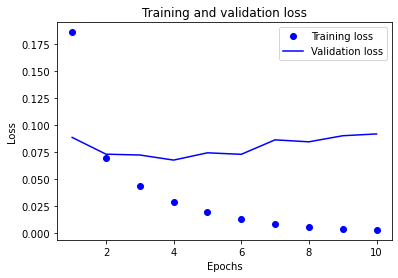

In [337]:
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

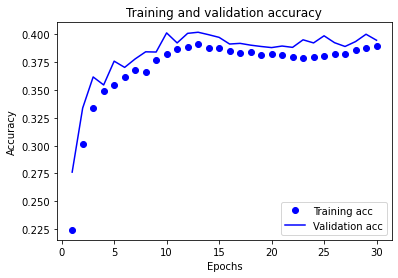

In [24]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [338]:
# Get the predicted classes:
# model.predict_classes() is depricated in TensorFlow 2.7+
# pred_classes = model.predict(train_images)
# alternate method:
pred_train=model.predict(train_images) 
pred_classes=np.argmax(pred_train, axis=1)

1719/1719 [==============================] - 2s 1ms/step


In [339]:
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[ 168,  118,  557,    0,    2,   27, 4537,    0,   35,    0],
       [   5, 5712,  133,    0,  154,   52,   45,    0,   76,    2],
       [ 207,  623, 1208,    0,   55,  104, 3161,    2,  102,    8],
       [  47, 3664,  698,    0,  388,  167,  314,   21,  240,   99],
       [   4,  792,   77,    0, 3127,   12,   31,   35,   16, 1213],
       [  74, 2702, 1084,    0,  205,  244,  275,   35,  314,   54],
       [  92,   62,  362,    0,    2,   29, 4851,    0,   19,    0],
       [   0,  261,   20,    0, 1072,    6,    5, 3386,    2,  963],
       [  32, 3522,  814,    0,  338,  233,   76,    9,  339,   26],
       [   7,  299,   21,    0, 1629,    4,   11, 1226,    7, 2250]], dtype=int64)

In [340]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

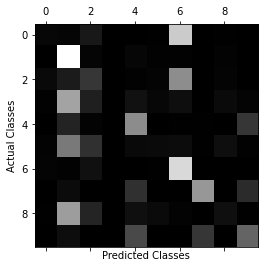

In [341]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_plot_mnist", tight_layout=False)
plt.show()

In [342]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

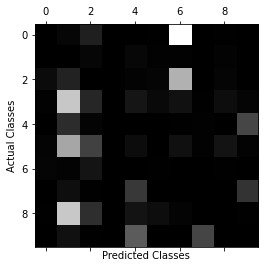

In [343]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_errors_plot_mnist_val", tight_layout=False)
plt.show()

In [31]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs # description of the layers

There are 2 layers


[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'hidden_layer_1')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'output_layer')>]

In [32]:
# Get the output of the hidden node for each of the 55000 training images
activations = activation_model.predict(train_images)
hidden_layer_activation = activations[0]
hidden_layer_activation.shape   #  hidden node has one activation value per training image

1719/1719 [==============================] - 2s 953us/step


(55000, 1)

In [33]:
print(f"The maximum activation value of the hidden node is {hidden_layer_activation.max()}")

The maximum activation value of the hidden node is 59.905113220214844


In [34]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (55000, 10)
The output for the first image are [0.    0.    0.    0.    0.005 0.    0.    0.709 0.    0.286]
The sum of the probabilities is (approximately) 1.0


In [35]:
boxplot_df = pd.DataFrame({'act_value':hidden_layer_activation.reshape(55000),
                           'pred_class':pred_classes})
boxplot_df.head()

act_value  pred_class
0  17.945610           7
1   2.618513           1
2   5.968791           9
3   0.000000           6
4   1.954962           1

<AxesSubplot:title={'center':'act_value'}, xlabel='pred_class'>

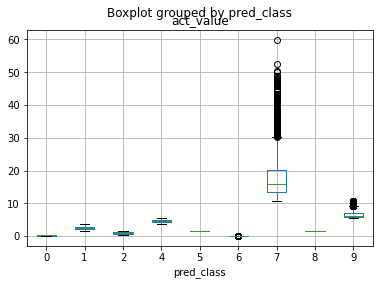

In [36]:
# To see how closely the hidden nodes activation values correlate with the class predictions
# Note that there were no 5s detected and that there were outliers for the activation values for the 6s
boxplot_df[['act_value','pred_class']].boxplot(by ='pred_class', column =['act_value'], grid = True) 

In [37]:
boxplot_df['pred_class'].value_counts() # Another way to verify what the boxplot is telling us

1    17755
6    13306
4     6972
2     4974
7     4714
9     4615
8     1150
5      878
0      636
Name: pred_class, dtype: int64

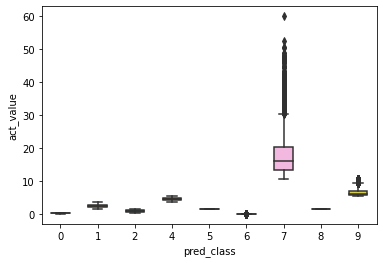

In [38]:
# Let us use seaborn for the boxplots this time.
import seaborn as sns
bplot = sns.boxplot(y='act_value', x='pred_class', 
                 data=boxplot_df, 
                 width=0.5,
                 palette="colorblind")

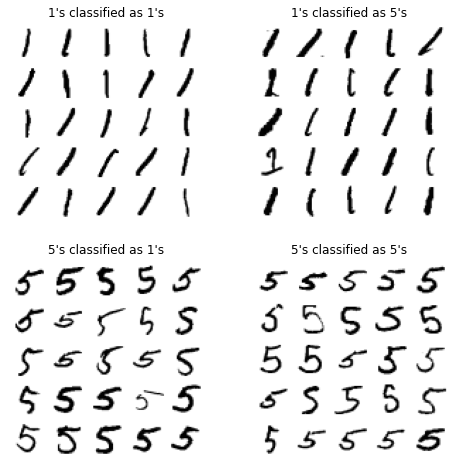

In [345]:


cl_a, cl_b = 1, 5
X_aa = train_images[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(8,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()



## Experiment 2

- 784 Input Nodes
- hidden layer: 2 nodes
- output layer: 10 nodes


In [39]:
# k.clear_session()
model = Sequential([
    Dense(name = 'hidden_layer_1', units=2, activation='relu', input_shape=[784]),
    Dense(name = 'output_layer', units = 10, activation ='softmax')
])

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 2)                 1570      
                                                                 
 output_layer (Dense)        (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(optimizer='rmsprop',
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])


In [42]:
history = model.fit( train_images
    , train_labels
    , epochs=30
    , validation_data=(val_images, val_labels)
    , callbacks=[tf.keras.callbacks.ModelCheckpoint("exp_2_optimized.h5",save_best_only=True,save_weights_only=False)] 
    )

Epoch 1/30
1719/1719 [==============================] - 8s 4ms/step - loss: 1.5841 - accuracy: 0.3950 - val_loss: 1.3221 - val_accuracy: 0.5302
Epoch 2/30
1719/1719 [==============================] - 7s 4ms/step - loss: 1.2458 - accuracy: 0.5568 - val_loss: 1.1720 - val_accuracy: 0.5940
Epoch 3/30
1719/1719 [==============================] - 8s 5ms/step - loss: 1.1490 - accuracy: 0.6004 - val_loss: 1.1116 - val_accuracy: 0.6290
Epoch 4/30
1719/1719 [==============================] - 8s 5ms/step - loss: 1.1002 - accuracy: 0.6220 - val_loss: 1.0747 - val_accuracy: 0.6368
Epoch 5/30
1719/1719 [==============================] - 8s 4ms/step - loss: 1.0665 - accuracy: 0.6366 - val_loss: 1.0465 - val_accuracy: 0.6512
Epoch 6/30
1719/1719 [==============================] - 8s 5ms/step - loss: 1.0430 - accuracy: 0.6447 - val_loss: 1.0272 - val_accuracy: 0.6548
Epoch 7/30
1719/1719 [==============================] - 8s 5ms/step - loss: 1.0271 - accuracy: 0.6517 - val_loss: 1.0121 - val_accuracy:

In [43]:
model = tf.keras.models.load_model("exp_2_optimized.h5")
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.9694 - accuracy: 0.7061


In [44]:
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.7060999870300293, test loss: 0.9694307446479797


In [45]:
history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

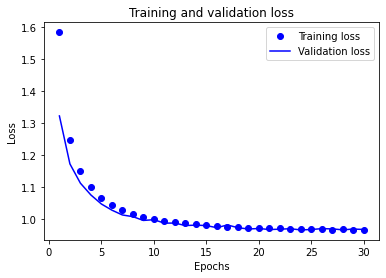

In [46]:
plt.clf()   # clear figure
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

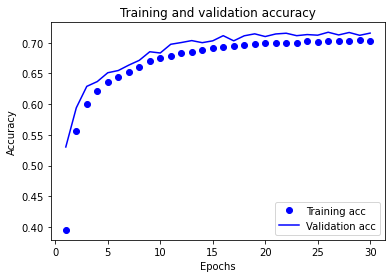

In [47]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [48]:
# Get the predicted classes:
# model.predict_classes() is depricated in TensorFlow 2.7+
# pred_classes = model.predict(train_images)
# alternate method:
pred_train=model.predict(train_images) 
pred_classes=np.argmax(pred_train, axis=1)

1719/1719 [==============================] - 2s 1ms/step


In [49]:
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[4617,    2,    0,   39,    7,  594,  115,   42,   21,    7],
       [   0, 5775,  138,   16,   37,   10,   21,    5,  173,    4],
       [  23,  204, 3840,  485,   63,  131,  334,   14,  365,   11],
       [ 104,   75,  774, 2045,   19,  894,  500,   70, 1128,   29],
       [   1,   14,    6,   31, 4339,   70,   14,   21,  122,  689],
       [ 268,   29,   54,  415,   75, 2842,  177,  465,  553,  109],
       [ 141,   17,  623,  483,   12,  188, 3843,    4,   98,    8],
       [  69,   35,    8,   15,  220,  339,    2, 3997,  234,  796],
       [  46,  305,  177,  447,  145,  924,   22,   73, 3171,   79],
       [  22,    4,    2,    3,  639,  128,    1,  423,   56, 4176]],
      dtype=int64)

<Figure size 432x288 with 0 Axes>

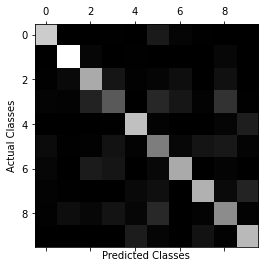

In [50]:
plt.clf()   # clear figure
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_plot_mnist", tight_layout=False)
plt.show()

In [51]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

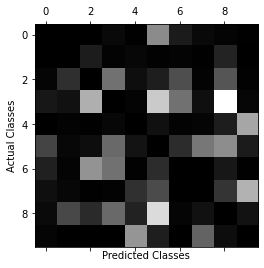

In [52]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_errors_plot_mnist_val", tight_layout=False)
plt.show()

In [53]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs # description of the layers

There are 2 layers


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'hidden_layer_1')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'output_layer')>]

In [54]:
# Get the output of the hidden node for each of the 55000 training images
activations = activation_model.predict(train_images)
hidden_layer_activation = activations[0]
hidden_layer_activation.shape   #  hidden node has one activation value per training image

1719/1719 [==============================] - 2s 1ms/step


(55000, 2)

In [55]:
hidden_node1_activation = hidden_layer_activation[:,0] # get activation values of the first hidden node
hidden_node2_activation = hidden_layer_activation[:,1] # get activation values of the second hidden node

print(f"The maximum activation value of the first hidden node is {hidden_node1_activation.max()}")
print(f"The maximum activation value of the second hidden node is {hidden_node2_activation.max()}")

The maximum activation value of the first hidden node is 38.17579650878906
The maximum activation value of the second hidden node is 63.17909240722656


In [56]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (55000, 10)
The output for the first image are [0.014 0.    0.    0.    0.    0.    0.    0.944 0.    0.042]
The sum of the probabilities is (approximately) 0.9999998807907104


In [57]:
scatterPlot_df =  pd.DataFrame({'act_value_h1':hidden_node1_activation,
                                'act_value_h2':hidden_node2_activation,
                                'pred_class':pred_classes})
scatterPlot_df.head()

act_value_h1  act_value_h2  pred_class
0     13.096180      0.952040           7
1      5.241128      6.664668           3
2      2.673984      0.000000           9
3      9.824480     11.739905           6
4      0.179157      4.295593           1

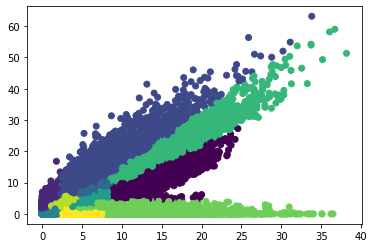

In [58]:
#plt.legend(loc='upper left', prop={'size':6}, bbox_to_anchor=(1,1),ncol=1)
plt.scatter(scatterPlot_df.act_value_h1, 
            scatterPlot_df.act_value_h2, 
            c=scatterPlot_df.pred_class,
            label=scatterPlot_df.pred_class)
plt.show()

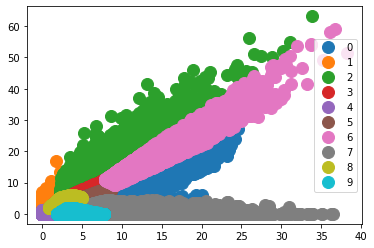

In [59]:
groups = scatterPlot_df.groupby('pred_class')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.act_value_h1, group.act_value_h2, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

## Experiment 3

- 784 Input Nodes
- hidden layer: 128 nodes
- output layer: 10 nodes


In [60]:
# k.clear_session()
model = Sequential([
    Dense(name = 'hidden_layer_1', units=128, activation='relu', input_shape=[784]),
    Dense(name = 'output_layer', units = 10, activation ='softmax')
])

In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               100480    
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(optimizer='rmsprop',
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [63]:
history = model.fit(train_images
    , train_labels
    , epochs=20
    , validation_data=(val_images, val_labels)
    , callbacks=[tf.keras.callbacks.ModelCheckpoint("exp_3_optimized.h5",save_best_only=True,save_weights_only=False)] 
    )

Epoch 1/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2680 - accuracy: 0.9225 - val_loss: 0.1364 - val_accuracy: 0.9598
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1288 - accuracy: 0.9625 - val_loss: 0.1006 - val_accuracy: 0.9690
Epoch 3/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0950 - accuracy: 0.9729 - val_loss: 0.1027 - val_accuracy: 0.9684
Epoch 4/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0760 - accuracy: 0.9781 - val_loss: 0.0810 - val_accuracy: 0.9768
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0647 - accuracy: 0.9816 - val_loss: 0.0822 - val_accuracy: 0.9770
Epoch 6/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0546 - accuracy: 0.9847 - val_loss: 0.0855 - val_accuracy: 0.9768
Epoch 7/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0476 - accuracy: 0.9870 - val_loss: 0.0875 - val_accuracy:

In [64]:
model = tf.keras.models.load_model("exp_3_optimized.h5")

In [65]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               100480    
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [66]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.0893 - accuracy: 0.9745


In [67]:
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.9745000004768372, test loss: 0.08933456242084503


In [68]:
history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

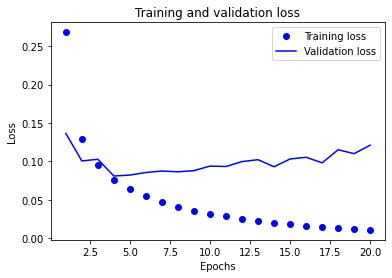

In [69]:
plt.clf()   # clear figure
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

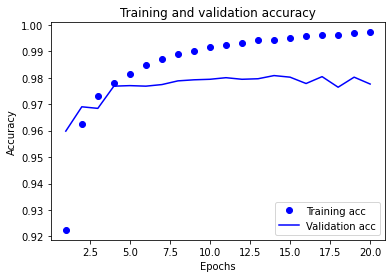

In [70]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [71]:
# Get the predicted classes:
# model.predict_classes() is depricated in TensorFlow 2.7+
# pred_classes = model.predict(train_images)
# alternate method:
pred_train=model.predict(train_images) 
pred_classes=np.argmax(pred_train, axis=1)

1719/1719 [==============================] - 2s 1ms/step


In [72]:
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[5407,    1,    4,    0,    3,    4,    4,    1,   11,    9],
       [   0, 6129,   14,    4,    4,    0,    1,    7,   13,    7],
       [  15,    4, 5395,    8,   11,    2,    1,   17,   12,    5],
       [   7,    4,   32, 5488,    1,   43,    2,   10,   34,   17],
       [   1,    6,    6,    0, 5217,    1,    5,    6,    9,   56],
       [   6,    1,    5,   11,    3, 4908,   17,    1,   21,   14],
       [  22,    6,    7,    0,    9,   18, 5344,    0,   11,    0],
       [   4,   10,   18,    1,   10,    1,    0, 5627,   18,   26],
       [   7,   14,   10,   11,    2,   10,    1,    1, 5315,   18],
       [   6,    2,    1,    9,   19,   10,    1,   17,   14, 5375]],
      dtype=int64)

<Figure size 432x288 with 0 Axes>

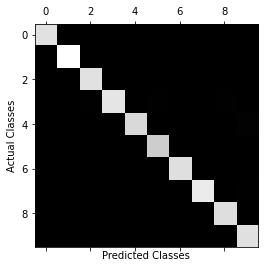

In [73]:
plt.clf()   # clear figure
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_plot_mnist", tight_layout=False)
plt.show()

In [74]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

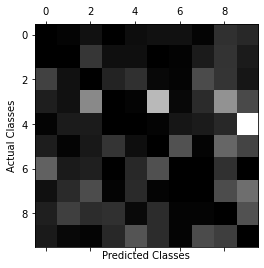

In [75]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_errors_plot_mnist_val", tight_layout=False)
plt.show()

Most problematic classifications (actual, predicted):
- 7, 9
- 4, 9
- 5, 6

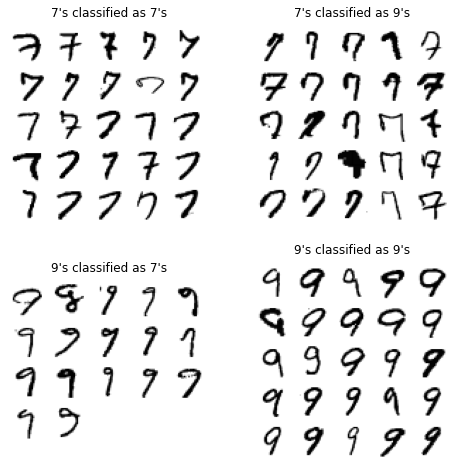

In [76]:
cl_a, cl_b = 7, 9
X_aa = train_images[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(8,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

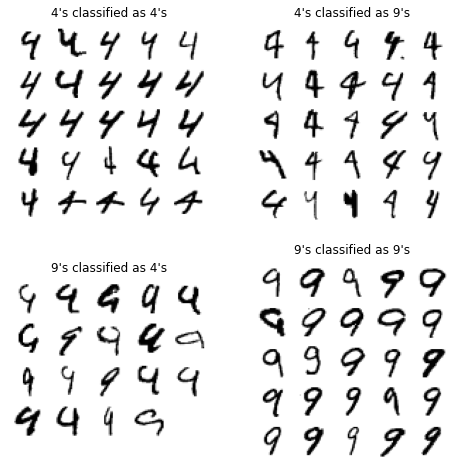

In [77]:
cl_a, cl_b = 4, 9
X_aa = train_images[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(8,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

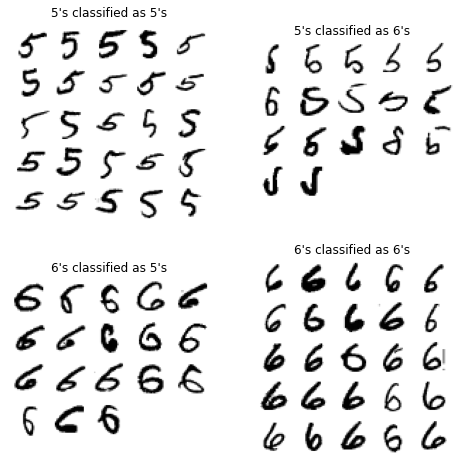

In [78]:
cl_a, cl_b = 5, 6
X_aa = train_images[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(8,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

### TO-DO: ACTIVATION EXTRACTION & SCATTERPLOT

In [79]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [80]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(train_images)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

1719/1719 [==============================] - 2s 1ms/step


(55000, 128)

In [81]:
output_layer_activations.shape

(55000, 10)

In [82]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 15.73847484588623


In [83]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (55000, 10)
The output for the first image are [0.    0.    0.001 0.028 0.    0.    0.    0.971 0.    0.   ]
The sum of the probabilities is (approximately) 0.9999999403953552


In [84]:
#Get the dataframe of all the node values
activation_data = {'actual_class':train_labels}
for k in range(0,128): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

0      1      2      3      4      5      6    7      8   \
actual_class  7.000  3.000  4.000  6.000  1.000  8.000  1.000  0.0  9.000   
act_val_0     0.000  0.162  0.000  0.249  2.135  2.756  2.438  0.0  0.000   
act_val_1     0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.000   
act_val_2     2.000  0.000  0.000  0.644  2.731  0.622  3.536  0.0  0.000   
act_val_3     3.421  0.707  0.000  0.000  1.284  0.000  1.596  0.0  0.412   
...             ...    ...    ...    ...    ...    ...    ...  ...    ...   
act_val_123   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.0  0.831   
act_val_124   2.964  0.000  0.000  0.000  0.000  0.280  0.000  0.0  0.000   
act_val_125   1.095  0.913  0.000  0.000  1.927  0.597  1.401  0.0  0.000   
act_val_126   0.588  0.000  0.741  0.000  0.000  0.000  0.000  0.0  0.326   
act_val_127   0.000  2.831  0.146  0.000  0.000  0.983  0.000  0.0  0.386   

                 9      10     11     12     13     14  
actual_class  8.000  0.000  3.000  1.000  2.000  7.000  
act_val_0     2.189  0.505  0.221  0.000  1.573  0.222  
act_val_1     0.000  1.581  0.000  0.000  0.000  0.000  
act_val_2     0.000  0.000  0.000  2.187  0.265  0.000  
act_val_3     0.000  0.000  1.149  1.404  0.000  1.738  
...             ...    ...    ...    ...    ...    ...  
act_val_123   0.000  0.000  0.000  0.000  0.000  2.235  
act_val_124   0.000  0.000  0.000  0.000  3.500  0.719  
act_val_125   1.482  0.000  1.138  2.877  0.000  0.000  
act_val_126   0.000  0.000  0.000  0.000  0.000  1.756  
act_val_127   0.075  0.000  2.622  0.000  0.000  0.000  

[129 rows x 15 columns]

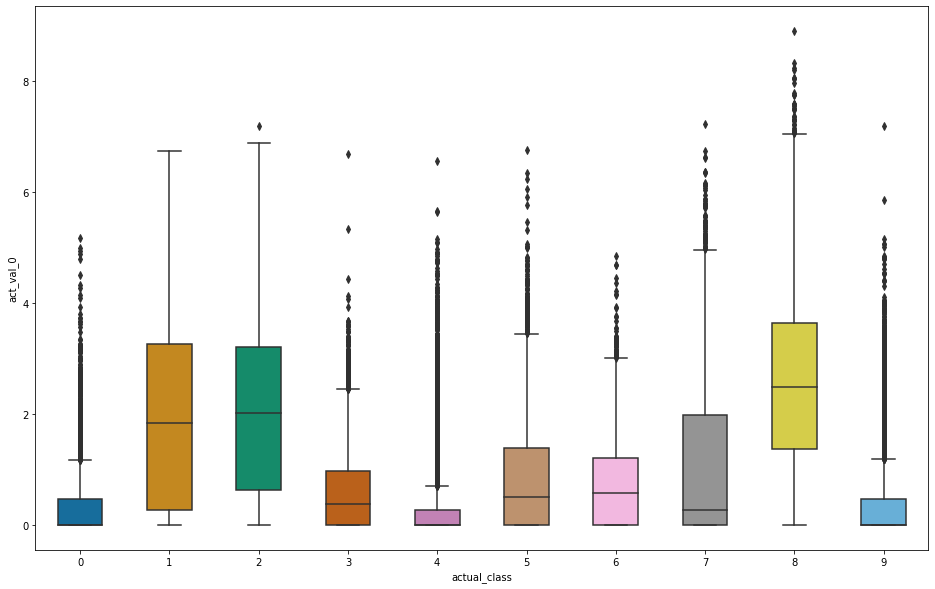

In [85]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
plt.figure(figsize=(16,10))
bplot = sns.boxplot(y='act_val_0', x='actual_class', 
                 data=activation_df[['act_val_0','actual_class']], 
                 width=0.5,
                 palette="colorblind")

In [86]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

actual_class range_of_act_values
0             0         [0.0, 5.18]
1             1         [0.0, 6.74]
2             2          [0.0, 7.2]
3             3         [0.0, 6.69]
4             4         [0.0, 6.55]
5             5         [0.0, 6.75]
6             6         [0.0, 4.84]
7             7         [0.0, 7.22]
8             8          [0.0, 8.9]
9             9         [0.0, 7.19]

In [87]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':train_labels}
for k in range(0,784): 
    pixel_data[f"pix_val_{k}"] = train_images[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

0    1    2    3    4    5    6    7    8    9    10   11   12  \
actual_class  7.0  3.0  4.0  6.0  1.0  8.0  1.0  0.0  9.0  8.0  0.0  3.0  1.0   
pix_val_0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
pix_val_1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
pix_val_2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
pix_val_3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
pix_val_779   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
pix_val_780   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
pix_val_781   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
pix_val_782   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
pix_val_783   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

               13   14  
actual_class  2.0  7.0  
pix_val_0     0.0  0.0  
pix_val_1     0.0  0.0  
pix_val_2     0.0  0.0  
pix_val_3     0.0  0.0  
...           ...  ...  
pix_val_779   0.0  0.0  
pix_val_780   0.0  0.0  
pix_val_781   0.0  0.0  
pix_val_782   0.0  0.0  
pix_val_783   0.0  0.0  

[785 rows x 15 columns]

In [88]:
pixel_df.pix_val_77.value_counts()

0.000000    54741
1.000000       24
0.996078       10
0.992157        9
0.050980        5
            ...  
0.670588        1
0.858824        1
0.239216        1
0.839216        1
0.819608        1
Name: pix_val_77, Length: 143, dtype: int64

In [89]:
pixel_df.pix_val_78.value_counts()

0.000000    54871
1.000000        5
0.992157        4
0.960784        4
0.098039        3
            ...  
0.047059        1
0.741176        1
0.568627        1
0.023529        1
0.501961        1
Name: pix_val_78, Length: 92, dtype: int64

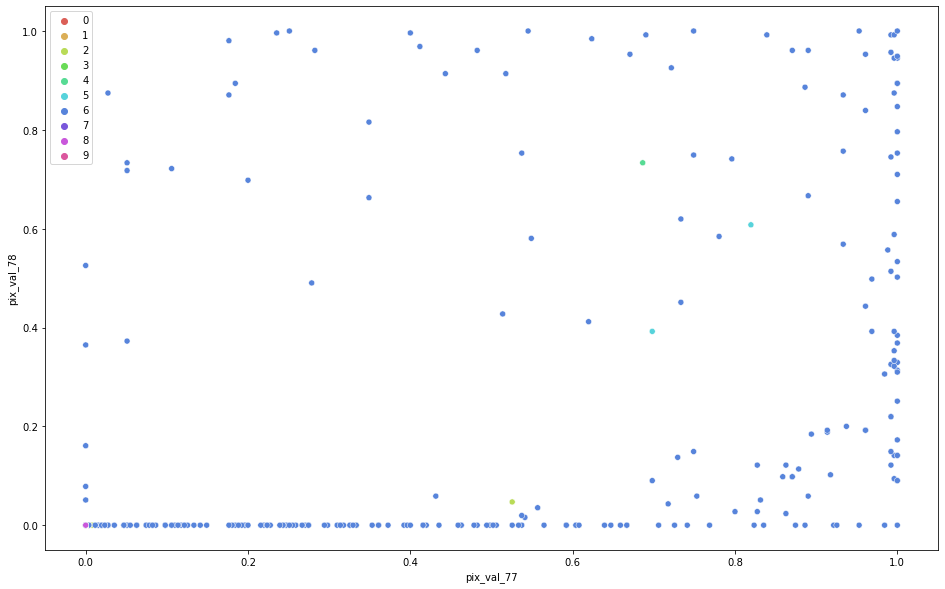

In [90]:
plt.figure(figsize=(16, 10))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');

In [91]:
# Separating out the features
features = [*pixel_data][1:] # ['pix_val_0', 'pix_val_1',...]
x = pixel_df.loc[:, features].values 

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [92]:
pixel_pca_df = pd.concat([principalDf, pixel_df[['actual_class']]], axis = 1)

In [93]:
pixel_pca_df.head().round(3)

principal component 1  principal component 2  actual_class
0                  0.725                  2.433             7
1                  0.473                 -1.005             3
2                 -0.094                  3.010             4
3                  0.221                  0.725             6
4                 -3.680                 -2.086             1

In [94]:
pca.explained_variance_ratio_

array([0.097, 0.071], dtype=float32)

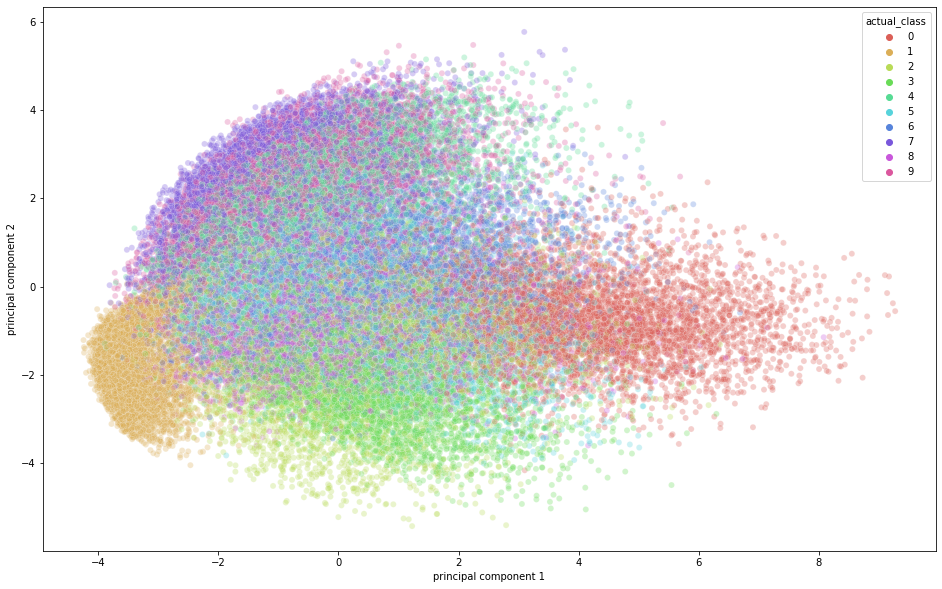

In [95]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="actual_class",
    palette=sns.color_palette("hls", 10),
    data=pixel_pca_df,
    legend="full",
    alpha=0.3
);

In [96]:
# Separating out the features
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
x = activation_df.loc[:, features].values 

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head().round(3)

principal component 1  principal component 2
0                 -1.369                  5.625
1                  0.319                 -5.544
2                 -2.361                  5.169
3                 -0.953                  0.642
4                 -5.158                 -3.531

In [97]:
activation_pca_df = pd.concat([principalDf, activation_df[['actual_class']]], axis = 1)
activation_pca_df.head().round(3)

principal component 1  principal component 2  actual_class
0                 -1.369                  5.625             7
1                  0.319                 -5.544             3
2                 -2.361                  5.169             4
3                 -0.953                  0.642             6
4                 -5.158                 -3.531             1

In [98]:
pca.explained_variance_ratio_

array([0.137, 0.117], dtype=float32)

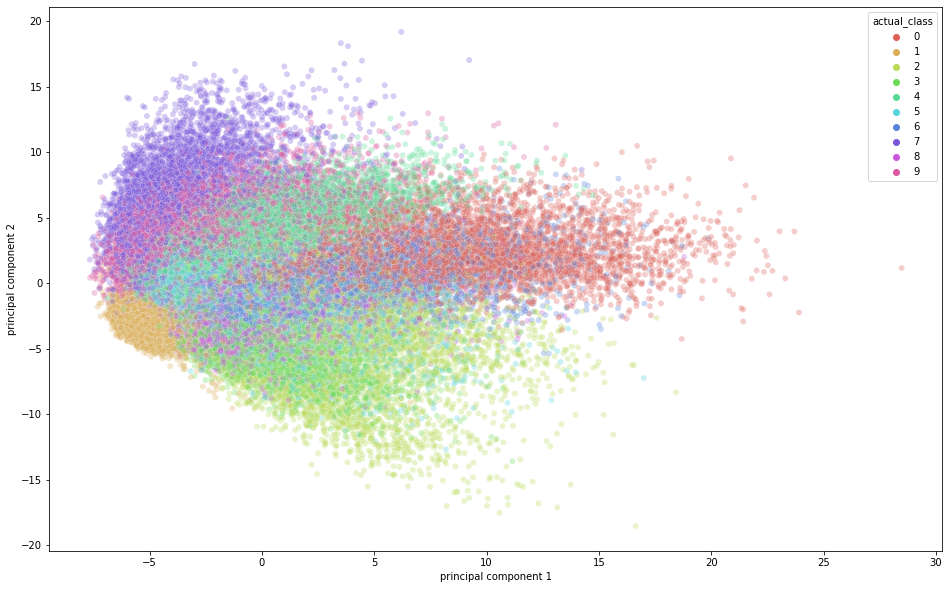

In [99]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="actual_class",
    palette=sns.color_palette("hls", 10),
    data=activation_pca_df,
    legend="full",
    alpha=0.3
);

In [100]:
# Separating out the features
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
x = activation_df.loc[:, features].values 

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca-one', 'pca-two', 'pca-three'])
principalDf.head(10).round(3).T

0      1      2      3      4      5      6       7      8  \
pca-one   -1.369  0.319 -2.361 -0.953 -5.158  1.228 -5.301  10.740 -1.685   
pca-two    5.625 -5.544  5.169  0.642 -3.531 -4.354 -4.357   3.895  3.624   
pca-three  6.654  5.957  0.584 -7.143 -2.957 -0.746 -2.084  -3.523  0.195   

               9  
pca-one    3.123  
pca-two   -5.684  
pca-three -0.392

In [101]:
pca.explained_variance_ratio_

array([0.137, 0.117, 0.106], dtype=float32)

In [102]:
activation_pca_df = pd.concat([principalDf, activation_df[['actual_class']]], axis = 1)
activation_pca_df.head().round(3)

pca-one  pca-two  pca-three  actual_class
0   -1.369    5.625      6.654             7
1    0.319   -5.544      5.957             3
2   -2.361    5.169      0.584             4
3   -0.953    0.642     -7.143             6
4   -5.158   -3.531     -2.957             1

In [103]:
activation_df.shape

(55000, 129)

In [104]:
N=55000
activation_df_subset = activation_df.iloc[:N].copy()
activation_df_subset.shape

(55000, 129)

In [105]:
data_subset = activation_df_subset[features].values
data_subset.shape

(55000, 128)

In [106]:
%%time
tsne = TSNE(n_components=2 # sorts nodes in ascending order,
            ,init='pca'
            ,learning_rate='auto'
            ,verbose=1
            ,perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 55000 samples in 0.007s...
[t-SNE] Computed neighbors for 55000 samples in 61.301s...
[t-SNE] Computed conditional probabilities for sample 1000 / 55000
[t-SNE] Computed conditional probabilities for sample 2000 / 55000
[t-SNE] Computed conditional probabilities for sample 3000 / 55000
[t-SNE] Computed conditional probabilities for sample 4000 / 55000
[t-SNE] Computed conditional probabilities for sample 5000 / 55000
[t-SNE] Computed conditional probabilities for sample 6000 / 55000
[t-SNE] Computed conditional probabilities for sample 7000 / 55000
[t-SNE] Computed conditional probabilities for sample 8000 / 55000
[t-SNE] Computed conditional probabilities for sample 9000 / 55000
[t-SNE] Computed conditional probabilities for sample 10000 / 55000
[t-SNE] Computed conditional probabilities for sample 11000 / 55000
[t-SNE] Computed conditional probabilities for sample 12000 / 55000
[t-SNE] Computed conditional probabilities for s

C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.731216
[t-SNE] KL divergence after 300 iterations: 3.901497
CPU times: total: 13min 8s
Wall time: 2min 31s


In [107]:
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

In [108]:
tsne_results

array([[0.267, 0.864],
       [0.437, 0.044],
       [0.571, 0.702],
       ...,
       [0.507, 0.446],
       [0.608, 0.559],
       [0.26 , 0.482]], dtype=float32)

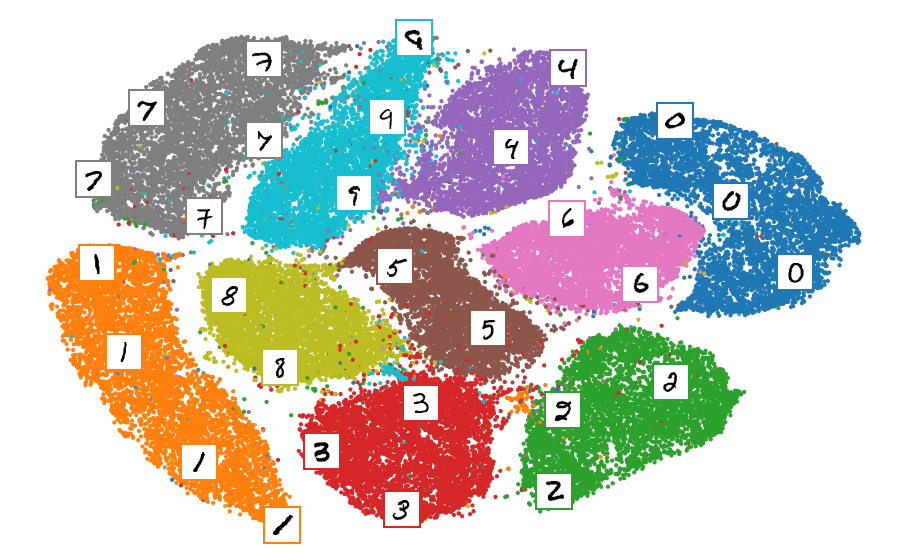

In [109]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], c=train_labels, s=10, cmap=cmap)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train_images[index].reshape(28,28), cmap="binary"),
            position, bboxprops={"edgecolor": cmap(train_labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 4

- 28x28 images (784 pixels) reduced to 154 input nodes via PCA (n_components=0.95)
- hidden layer: 85 nodes
- output layer: 10 nodes


In [110]:
pca = PCA(n_components=0.95)
train_images_red = pca.fit_transform(train_images)
val_images_red = pca.transform(val_images)
test_images_red = pca.transform(test_images)

In [111]:
test_images_red.shape, train_images_red.shape, val_images_red.shape

((10000, 154), (55000, 154), (5000, 154))

In [112]:
#k.clear_session()

model = Sequential([
    Dense(name = 'hidden_layer_1', units=85, activation='relu', input_shape=[154]),
    Dense(name = 'output_layer', units = 10, activation ='softmax')
])

In [113]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 85)                13175     
                                                                 
 output_layer (Dense)        (None, 10)                860       
                                                                 
Total params: 14,035
Trainable params: 14,035
Non-trainable params: 0
_________________________________________________________________


In [114]:
model.compile(optimizer='rmsprop',
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [115]:
history = model.fit(train_images_red
    , train_labels
    , epochs=15
    , validation_data=(val_images_red, val_labels)
    , callbacks=[tf.keras.callbacks.ModelCheckpoint("exp_4_optimized.h5",save_best_only=True,save_weights_only=False)] 
    )

Epoch 1/15
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3524 - accuracy: 0.9027 - val_loss: 0.1715 - val_accuracy: 0.9530
Epoch 2/15
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1450 - accuracy: 0.9582 - val_loss: 0.1267 - val_accuracy: 0.9666
Epoch 3/15
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1029 - accuracy: 0.9707 - val_loss: 0.1120 - val_accuracy: 0.9688
Epoch 4/15
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0790 - accuracy: 0.9779 - val_loss: 0.1012 - val_accuracy: 0.9692
Epoch 5/15
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0640 - accuracy: 0.9817 - val_loss: 0.0944 - val_accuracy: 0.9718
Epoch 6/15
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0530 - accuracy: 0.9852 - val_loss: 0.0917 - val_accuracy: 0.9752
Epoch 7/15
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0441 - accuracy: 0.9878 - val_loss: 0.0937 - val_accuracy:

In [116]:
model = tf.keras.models.load_model("exp_4_optimized.h5")

In [117]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 85)                13175     
                                                                 
 output_layer (Dense)        (None, 10)                860       
                                                                 
Total params: 14,035
Trainable params: 14,035
Non-trainable params: 0
_________________________________________________________________


In [118]:
test_loss, test_acc = model.evaluate(test_images_red, test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.0888 - accuracy: 0.9771


In [119]:
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.9771000146865845, test loss: 0.08875063061714172


In [120]:
history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

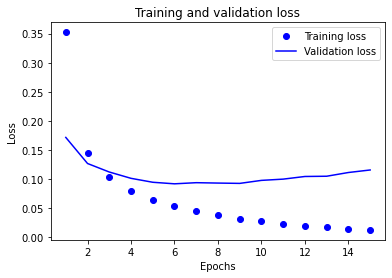

In [121]:
plt.clf()   # clear figure
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

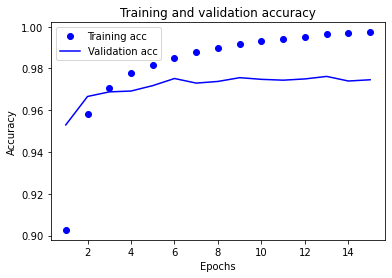

In [122]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [123]:
# Get the predicted classes:
# model.predict_classes() is depricated in TensorFlow 2.7+
# pred_classes = model.predict(train_images)
# alternate method:
pred_train=model.predict(train_images_red) 
pred_classes=np.argmax(pred_train, axis=1)

1719/1719 [==============================] - 2s 1ms/step


In [124]:
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[5416,    0,    4,    1,    2,    1,    9,    2,    3,    6],
       [   0, 6135,   10,    7,    7,    1,    1,   12,    4,    2],
       [   7,    2, 5411,    6,   10,    2,    1,   20,    8,    3],
       [   1,    1,   24, 5532,    1,   26,    0,   22,   16,   15],
       [   1,    4,    3,    1, 5277,    0,    4,    2,    3,   12],
       [   4,    2,    3,    9,    3, 4937,   16,    1,    2,   10],
       [   3,    1,    0,    0,    6,    8, 5399,    0,    0,    0],
       [   2,    6,   11,    3,   12,    1,    0, 5662,    2,   16],
       [   4,   13,    8,    4,    5,    8,    3,    4, 5331,    9],
       [   7,    2,    0,    1,   24,    7,    0,   18,    5, 5390]],
      dtype=int64)

<Figure size 432x288 with 0 Axes>

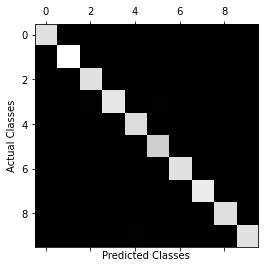

In [125]:
plt.clf()   # clear figure
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_plot_mnist", tight_layout=False)
plt.show()

In [126]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

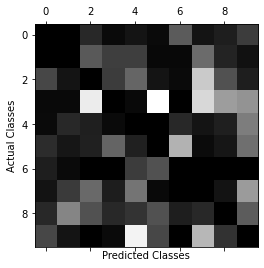

In [127]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_errors_plot_mnist_val", tight_layout=False)
plt.show()

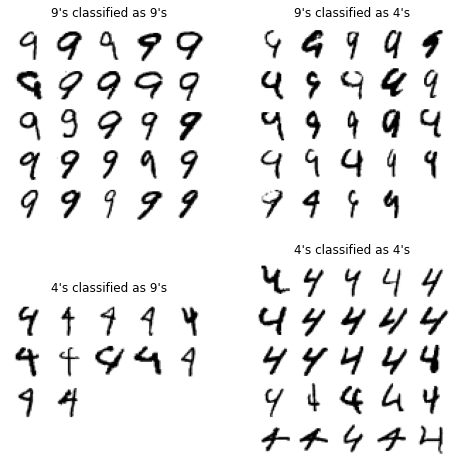

In [128]:
cl_a, cl_b = 9, 4
X_aa = train_images[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(8,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

### TO-DO: ACTIVATION EXTRACTION & SCATTERPLOT

In [129]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

In [130]:
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [131]:
print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [132]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(train_images_red)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 85 hidden nodes has one activation value per training image


1719/1719 [==============================] - 2s 1ms/step


(55000, 85)

In [133]:
output_layer_activations.shape


(55000, 10)

In [134]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 9.45744800567627


In [135]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")


The output node has shape (55000, 10)
The output for the first image are [0.    0.    0.001 0.027 0.    0.    0.    0.972 0.    0.001]
The sum of the probabilities is (approximately) 1.0000001192092896


In [136]:
#Get the dataframe of all the node values
activation_data = {'actual_class':train_labels}
for k in range(0,85): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

0      1      2      3      4      5      6      7      8   \
actual_class  7.000  3.000  4.000  6.000  1.000  8.000  1.000  0.000  9.000   
act_val_0     0.000  1.859  0.000  0.000  1.129  0.516  1.581  0.000  0.000   
act_val_1     0.293  0.000  0.827  0.000  1.070  1.208  1.102  0.000  0.147   
act_val_2     0.000  0.141  0.000  0.737  1.408  1.273  0.063  3.833  0.000   
act_val_3     2.055  0.058  0.000  0.000  0.914  0.000  1.679  0.000  1.428   
...             ...    ...    ...    ...    ...    ...    ...    ...    ...   
act_val_80    1.711  0.000  1.373  0.821  0.000  0.000  0.000  3.878  0.907   
act_val_81    0.871  0.621  3.867  2.131  0.000  0.000  0.000  1.830  2.584   
act_val_82    0.000  0.547  0.198  0.809  0.682  1.480  0.109  1.260  0.079   
act_val_83    0.708  0.766  0.570  0.000  0.381  0.000  0.144  0.000  2.058   
act_val_84    0.105  0.000  0.680  0.000  0.000  0.000  0.000  0.000  0.949   

                 9      10     11     12     13     14  
actual_class  8.000  0.000  3.000  1.000  2.000  7.000  
act_val_0     1.355  0.000  2.952  1.482  3.110  0.000  
act_val_1     0.885  0.000  0.000  0.124  0.000  0.000  
act_val_2     0.000  0.896  0.000  2.828  0.000  0.000  
act_val_3     0.000  0.000  0.000  0.959  0.000  0.883  
...             ...    ...    ...    ...    ...    ...  
act_val_80    0.115  3.786  0.000  0.000  2.188  0.000  
act_val_81    0.000  0.233  0.470  0.000  1.718  0.000  
act_val_82    0.554  0.000  0.000  0.000  0.707  0.000  
act_val_83    0.395  1.037  0.000  0.161  0.000  2.523  
act_val_84    0.000  0.000  0.000  0.000  0.000  2.890  

[86 rows x 15 columns]

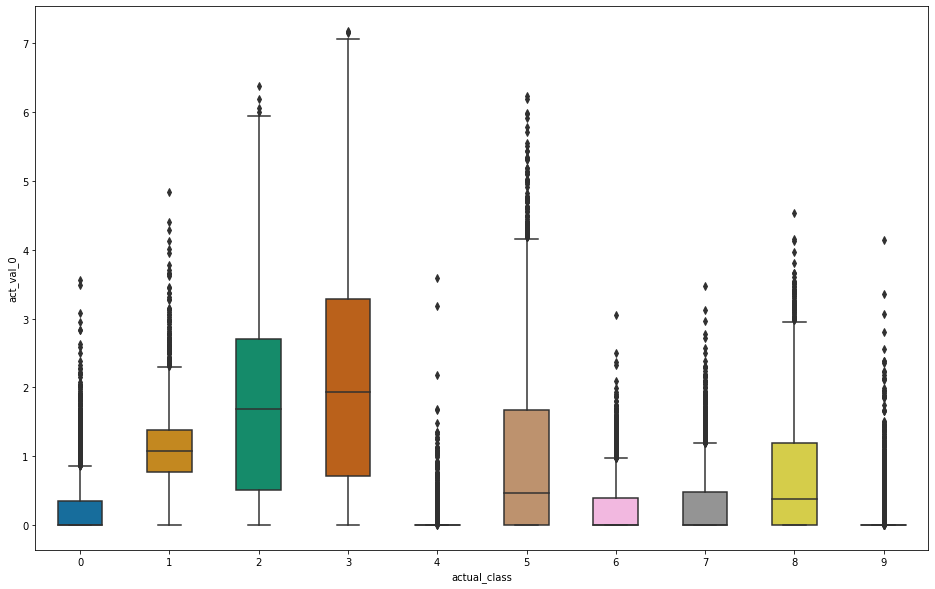

In [137]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
plt.figure(figsize=(16,10))
bplot = sns.boxplot(y='act_val_0', x='actual_class', 
                 data=activation_df[['act_val_0','actual_class']], 
                 width=0.5,
                 palette="colorblind")

In [138]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})


actual_class range_of_act_values
0             0         [0.0, 3.57]
1             1         [0.0, 4.84]
2             2         [0.0, 6.38]
3             3         [0.0, 7.18]
4             4         [0.0, 3.59]
5             5         [0.0, 6.23]
6             6         [0.0, 3.05]
7             7         [0.0, 3.48]
8             8         [0.0, 4.54]
9             9         [0.0, 4.14]

In [139]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':train_labels}
for k in range(0,154): 
    pixel_data[f"pix_val_{k}"] = train_images_red[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T


0      1      2      3      4      5      6      7      8   \
actual_class  7.000  3.000  4.000  6.000  1.000  8.000  1.000  0.000  9.000   
pix_val_0     0.725  0.473 -0.094  0.221 -3.680  1.304 -3.645  6.441 -0.511   
pix_val_1     2.433 -1.005  3.010  0.726 -2.086 -0.938 -2.637 -0.618  2.159   
pix_val_2    -1.538 -0.501 -2.129  2.278  0.551  1.223  0.458  1.207 -2.395   
pix_val_3     2.444 -3.738 -0.839  1.903  0.908 -2.803  0.121 -0.585  0.948   
...             ...    ...    ...    ...    ...    ...    ...    ...    ...   
pix_val_149  -0.242 -0.161 -0.033  0.102  0.082  0.114 -0.094 -0.166  0.262   
pix_val_150   0.115  0.105  0.006 -0.040  0.061 -0.050  0.130  0.191  0.011   
pix_val_151  -0.366 -0.218  0.013  0.048 -0.116 -0.117  0.116 -0.141  0.022   
pix_val_152   0.063 -0.148 -0.125  0.071 -0.007 -0.083  0.046 -0.121 -0.017   
pix_val_153   0.264 -0.007  0.036 -0.028 -0.021  0.087 -0.055 -0.071 -0.183   

                 9      10     11     12     13     14  
actual_class  8.000  0.000  3.000  1.000  2.000  7.000  
pix_val_0     1.735  5.037  0.704 -3.438  3.187 -1.907  
pix_val_1    -2.033 -1.002 -2.985 -0.737 -1.372  1.918  
pix_val_2    -0.173 -1.918 -1.507 -0.137 -0.065 -0.498  
pix_val_3    -1.992  0.636 -1.160  0.162 -2.585  0.126  
...             ...    ...    ...    ...    ...    ...  
pix_val_149   0.170 -0.033  0.044  0.011  0.184  0.051  
pix_val_150   0.439 -0.139 -0.018 -0.115 -0.028  0.050  
pix_val_151  -0.228 -0.135  0.150  0.002  0.108 -0.111  
pix_val_152  -0.283  0.078 -0.002 -0.080 -0.006 -0.256  
pix_val_153  -0.041  0.132 -0.142  0.173 -0.105 -0.268  

[155 rows x 15 columns]

In [140]:
pixel_df.pix_val_77.value_counts()


-0.130066    2
-0.081261    2
-0.216875    2
 0.316512    2
 0.078540    2
            ..
-0.097103    1
-0.040640    1
 0.232490    1
 0.125833    1
 0.271154    1
Name: pix_val_77, Length: 54981, dtype: int64

In [141]:
pixel_df.pix_val_78.value_counts()


 0.174541    2
-0.147862    2
-0.263049    2
 0.401319    2
-0.161656    2
            ..
-0.579717    1
 0.121773    1
 0.007243    1
-0.435647    1
-0.239586    1
Name: pix_val_78, Length: 54984, dtype: int64

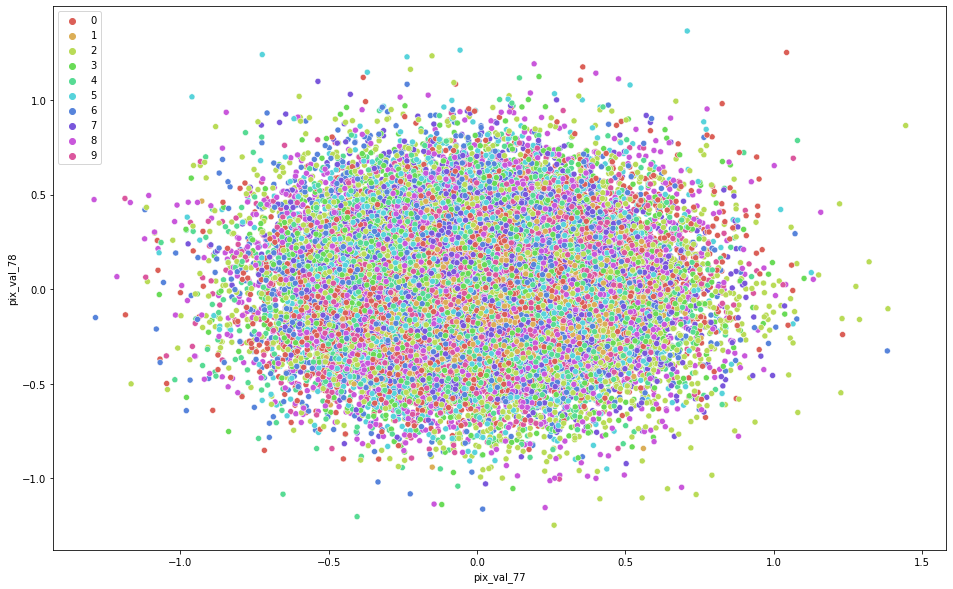

In [142]:
plt.figure(figsize=(16, 10))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');


In [143]:
# Separating out the features
features = [*pixel_data][1:] # ['pix_val_0', 'pix_val_1',...]
x = pixel_df.loc[:, features].values 

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [144]:
pixel_pca_df = pd.concat([principalDf, pixel_df[['actual_class']]], axis = 1)


In [145]:
pixel_pca_df.head().round(3)


principal component 1  principal component 2  actual_class
0                  0.725                  2.432             7
1                  0.473                 -1.005             3
2                 -0.094                  3.010             4
3                  0.221                  0.726             6
4                 -3.680                 -2.086             1

In [146]:
pca.explained_variance_ratio_


array([0.102, 0.074], dtype=float32)

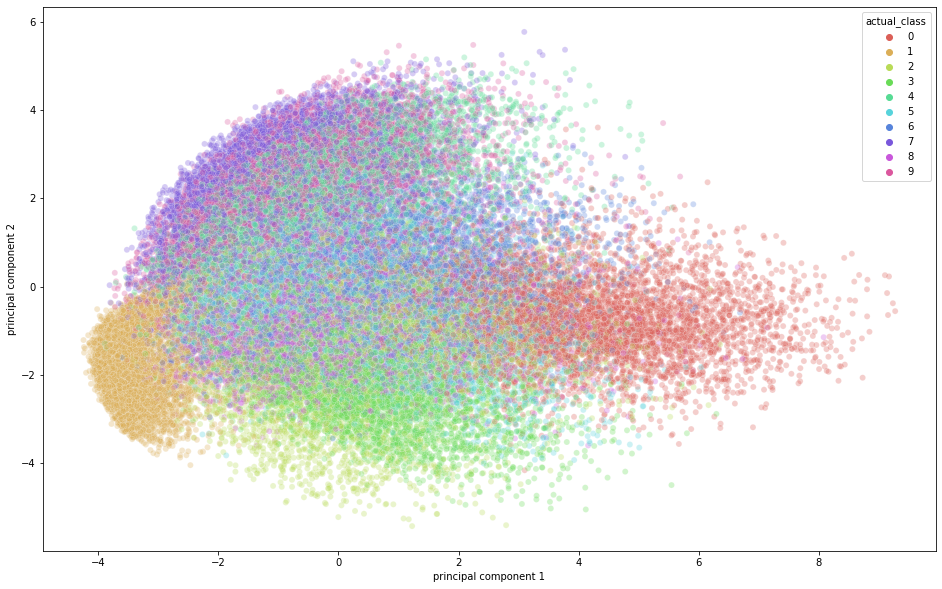

In [147]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="actual_class",
    palette=sns.color_palette("hls", 10),
    data=pixel_pca_df,
    legend="full",
    alpha=0.3
);


In [148]:
# Separating out the features
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
x = activation_df.loc[:, features].values 

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head().round(3)

principal component 1  principal component 2
0                 -0.984                 -2.412
1                 -1.999                  3.900
2                 -1.267                 -3.293
3                  1.842                 -1.970
4                 -2.402                  1.409

In [149]:
activation_pca_df = pd.concat([principalDf, activation_df[['actual_class']]], axis = 1)
activation_pca_df.head().round(3)

principal component 1  principal component 2  actual_class
0                 -0.984                 -2.412             7
1                 -1.999                  3.900             3
2                 -1.267                 -3.293             4
3                  1.842                 -1.970             6
4                 -2.402                  1.409             1

In [150]:
pca.explained_variance_ratio_


array([0.113, 0.103], dtype=float32)

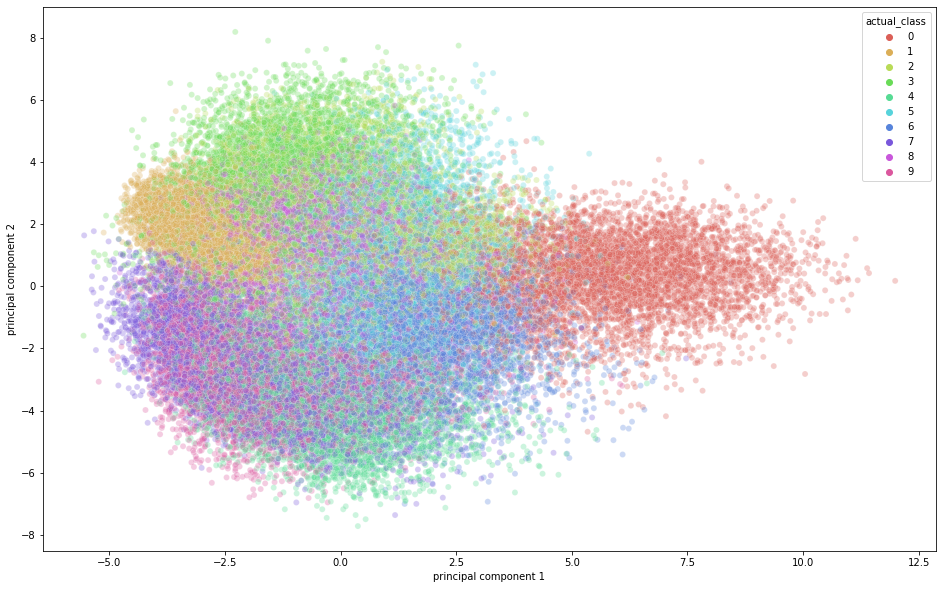

In [151]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="actual_class",
    palette=sns.color_palette("hls", 10),
    data=activation_pca_df,
    legend="full",
    alpha=0.3
);

In [152]:
# Separating out the features
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
x = activation_df.loc[:, features].values 

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca-one', 'pca-two', 'pca-three'])
principalDf.head(10).round(3).T

0      1      2      3      4      5      6      7      8  \
pca-one   -0.984 -1.999 -1.267  1.842 -2.402  2.034 -3.448  7.792 -1.304   
pca-two   -2.412  3.900 -3.293 -1.970  1.409  2.495  2.616 -0.098 -3.094   
pca-three  1.218  3.684  2.061 -2.877 -2.253  0.982 -2.117  0.324  1.362   

               9  
pca-one    0.358  
pca-two    3.606  
pca-three  0.412

In [153]:
pca.explained_variance_ratio_


array([0.113, 0.103, 0.074], dtype=float32)

In [154]:
activation_pca_df = pd.concat([principalDf, activation_df[['actual_class']]], axis = 1)
activation_pca_df.head().round(3)

pca-one  pca-two  pca-three  actual_class
0   -0.984   -2.412      1.218             7
1   -1.999    3.900      3.684             3
2   -1.267   -3.293      2.061             4
3    1.842   -1.970     -2.877             6
4   -2.402    1.409     -2.253             1

In [155]:
activation_df.shape


(55000, 86)

In [156]:
N=55000
activation_df_subset = activation_df.iloc[:N].copy()
activation_df_subset.shape

(55000, 86)

In [157]:
data_subset = activation_df_subset[features].values
data_subset.shape

(55000, 85)

In [158]:
%%time
tsne = TSNE(n_components=2 # sorts nodes in ascending order,
# tsne = TSNE(n_components=.95 # get nodes to explain 95% of the variance
            ,init='pca'
            ,learning_rate='auto'
            ,verbose=1
            ,perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 55000 samples in 0.005s...
[t-SNE] Computed neighbors for 55000 samples in 56.849s...
[t-SNE] Computed conditional probabilities for sample 1000 / 55000
[t-SNE] Computed conditional probabilities for sample 2000 / 55000
[t-SNE] Computed conditional probabilities for sample 3000 / 55000
[t-SNE] Computed conditional probabilities for sample 4000 / 55000
[t-SNE] Computed conditional probabilities for sample 5000 / 55000
[t-SNE] Computed conditional probabilities for sample 6000 / 55000
[t-SNE] Computed conditional probabilities for sample 7000 / 55000
[t-SNE] Computed conditional probabilities for sample 8000 / 55000
[t-SNE] Computed conditional probabilities for sample 9000 / 55000
[t-SNE] Computed conditional probabilities for sample 10000 / 55000
[t-SNE] Computed conditional probabilities for sample 11000 / 55000
[t-SNE] Computed conditional probabilities for sample 12000 / 55000
[t-SNE] Computed conditional probabilities for s

C:\Users\Reed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.573837
[t-SNE] KL divergence after 300 iterations: 3.968366
CPU times: total: 13min 44s
Wall time: 2min 30s


In [159]:
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())


In [160]:
tsne_results


array([[0.157, 0.312],
       [0.303, 0.849],
       [0.549, 0.088],
       ...,
       [0.609, 0.537],
       [0.774, 0.476],
       [0.285, 0.405]], dtype=float32)

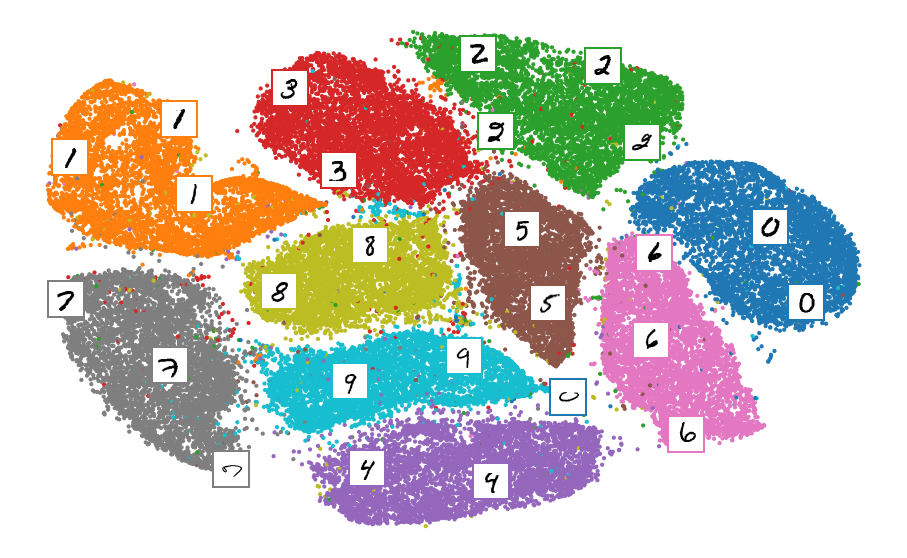

In [161]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], c=train_labels, s=10, cmap=cmap)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(train_images[index].reshape(28,28), cmap="binary"),
            position, bboxprops={"edgecolor": cmap(train_labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Experiment 5

- 28x28 images (784 pixels) dimensionality reduction via random forests
- hidden layer: 85 nodes
- output layer: 10 nodes


In [162]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(train_images,train_labels)

RandomForestClassifier(random_state=42)

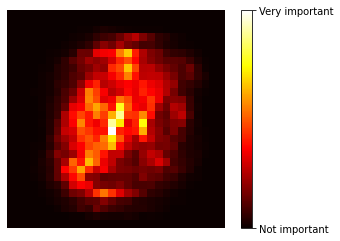

In [163]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

# plt.savefig("mnist_feature_importance_plot")
plt.show()

In [164]:
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

70

In [165]:
# Create training, validation and test images using just the 70 pixel locations obtained above
train_images_sm = train_images[:,idx]
val_images_sm = val_images[:,idx]
test_images_sm = test_images[:,idx]
train_images_sm.shape, val_images.shape, test_images_sm.shape # the reduced images have dimension 70

((55000, 70), (5000, 784), (10000, 70))

In [166]:
# to convert an index n, 0<= n < 784
def pair(n,size):
    x = n//size 
    y = n%size
    return x,y

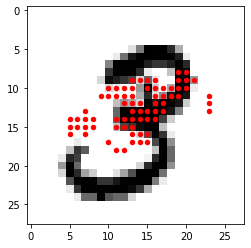

In [167]:
plt.imshow(train_images[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

In [168]:
model = Sequential([
    Dense(name = 'hidden_layer_1', units=85, activation='relu', input_shape=(70,)),
    Dense(name = 'output_layer', units = 10, activation ='softmax')
])

In [169]:
model.summary() # prints a summary representation of the odel



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 85)                6035      
                                                                 
 output_layer (Dense)        (None, 10)                860       
                                                                 
Total params: 6,895
Trainable params: 6,895
Non-trainable params: 0
_________________________________________________________________


In [170]:
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [171]:
history = model.fit(train_images_sm
    , train_labels
    , epochs=30
    , validation_data=(val_images_sm, val_labels)
    , callbacks=[tf.keras.callbacks.ModelCheckpoint("exp_5_optimized.h5",save_best_only=True,save_weights_only=False)] 
    )

Epoch 1/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6213 - accuracy: 0.8157 - val_loss: 0.4293 - val_accuracy: 0.8770
Epoch 2/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4022 - accuracy: 0.8773 - val_loss: 0.3498 - val_accuracy: 0.8972
Epoch 3/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3349 - accuracy: 0.8980 - val_loss: 0.3015 - val_accuracy: 0.9078
Epoch 4/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2952 - accuracy: 0.9113 - val_loss: 0.2717 - val_accuracy: 0.9182
Epoch 5/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2693 - accuracy: 0.9180 - val_loss: 0.2493 - val_accuracy: 0.9252
Epoch 6/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2514 - accuracy: 0.9235 - val_loss: 0.2413 - val_accuracy: 0.9278
Epoch 7/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2384 - accuracy: 0.9280 - val_loss: 0.2252 - val_accuracy:

In [172]:
model = tf.keras.models.load_model("exp_5_optimized.h5")
test_loss, test_acc = model.evaluate(test_images_sm, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.2281 - accuracy: 0.9308


In [173]:
print(f'test acc: {test_acc}, test loss: {test_loss}')

test acc: 0.9308000206947327, test loss: 0.22806531190872192


In [174]:
history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)


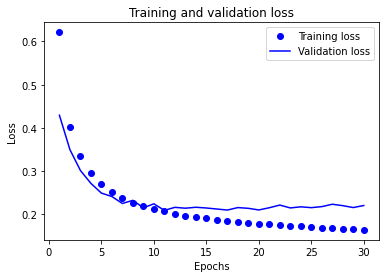

In [175]:
plt.clf()   # clear figure
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

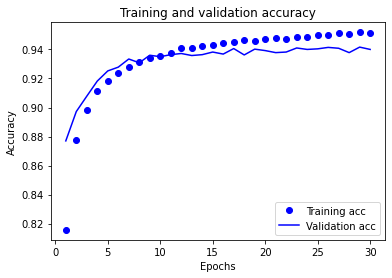

In [176]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [177]:
# Get the predicted classes:
# model.predict_classes() is depricated in TensorFlow 2.7+
# pred_classes = model.predict(train_images)
# alternate method:
pred_train=model.predict(train_images_sm) 
pred_classes=np.argmax(pred_train, axis=1)

conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

1719/1719 [==============================] - 2s 994us/step


array([[5234,    2,   32,    6,    4,   26,   70,   16,   35,   19],
       [   4, 6066,   37,    2,    9,    2,   10,   20,   26,    3],
       [  42,   39, 5045,   31,   40,   27,   37,  118,   47,   44],
       [  19,    4,   76, 5220,   11,  115,    4,   66,   63,   60],
       [   6,   11,   21,    8, 5000,   10,   47,   23,   41,  140],
       [  60,   18,   30,  182,   18, 4447,   72,    9,   64,   87],
       [  45,   15,   29,    3,   21,   24, 5247,    1,   27,    5],
       [   9,   18,   86,   17,   24,    3,    0, 5453,   21,   84],
       [  14,   34,   54,   39,   29,   34,   48,   14, 5061,   62],
       [  11,   11,   33,   64,   78,   36,    8,   89,   63, 5061]],
      dtype=int64)

<Figure size 432x288 with 0 Axes>

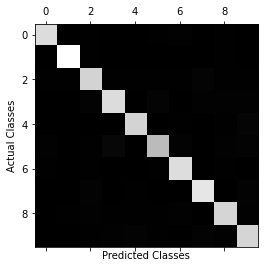

In [178]:
plt.clf()   # clear figure
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_plot_mnist", tight_layout=False)
plt.show()

In [179]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

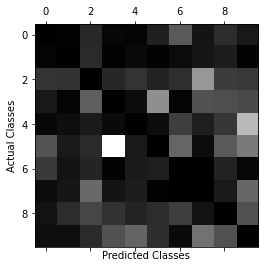

In [180]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_errors_plot_mnist_val", tight_layout=False)
plt.show()

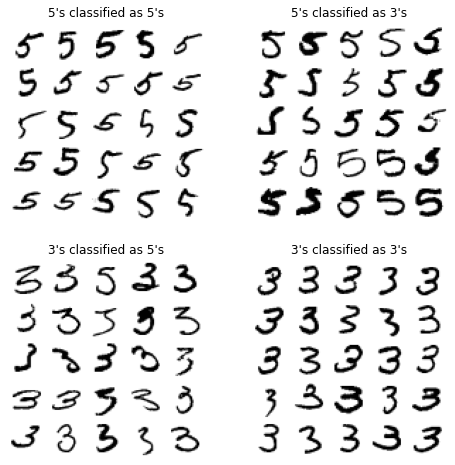

In [181]:
cl_a, cl_b = 5, 3
X_aa = train_images[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(8,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

### TO-DO: ACTIVATION EXTRACTION & SCATTERPLOT

- RF to 70 elements not as good compared to 128 NN and PCA
- accuracy after 30 epochs not as good

## Experiment 6

- 28x28 images (784 pixels)
- hidden layer: 256 nodes
- output layer: 10 nodes

In [182]:
#k.clear_session()
model = Sequential([
    Dense(name = 'hidden_layer_1', units=256, activation='relu', input_shape=[784]),
    Dense(name = 'output_layer', units = 10, activation ='softmax')
])

In [183]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 256)               200960    
                                                                 
 output_layer (Dense)        (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


In [184]:
model.compile(optimizer='rmsprop',
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])
history = model.fit(train_images
    , train_labels
    , epochs=15
    , validation_data=(val_images, val_labels)
    , callbacks=[tf.keras.callbacks.ModelCheckpoint("exp_6_optimized.h5",save_best_only=True,save_weights_only=False)] 
    )

Epoch 1/15
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2357 - accuracy: 0.9313 - val_loss: 0.1170 - val_accuracy: 0.9676
Epoch 2/15
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1053 - accuracy: 0.9694 - val_loss: 0.0902 - val_accuracy: 0.9740
Epoch 3/15
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0763 - accuracy: 0.9774 - val_loss: 0.0889 - val_accuracy: 0.9756
Epoch 4/15
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0592 - accuracy: 0.9829 - val_loss: 0.0702 - val_accuracy: 0.9816
Epoch 5/15
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0498 - accuracy: 0.9862 - val_loss: 0.0769 - val_accuracy: 0.9792
Epoch 6/15
1719/1719 [==============================] - 9s 6ms/step - loss: 0.0408 - accuracy: 0.9884 - val_loss: 0.0805 - val_accuracy: 0.9792
Epoch 7/15
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0350 - accuracy: 0.9904 - val_loss: 0.0844 - val_accura

In [185]:
model = tf.keras.models.load_model("exp_6_optimized.h5")
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 256)               200960    
                                                                 
 output_layer (Dense)        (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


In [186]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 1s 3ms/step - loss: 0.0808 - accuracy: 0.9769
test acc: 0.9768999814987183, test loss: 0.08081602305173874


In [187]:
history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

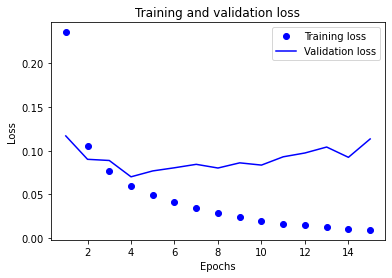

In [188]:
plt.clf()   # clear figure
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

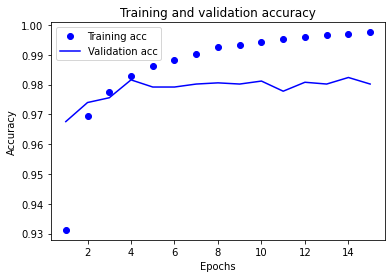

In [189]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [190]:
# Get the predicted classes:
# model.predict_classes() is depricated in TensorFlow 2.7+
# pred_classes = model.predict(train_images)
# alternate method:
pred_train=model.predict(train_images) 
pred_classes=np.argmax(pred_train, axis=1)

1719/1719 [==============================] - 3s 2ms/step


In [191]:
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[5424,    0,    2,    0,    0,    3,    6,    1,    3,    5],
       [   0, 6134,   11,    4,    4,    0,    1,   10,    8,    7],
       [   9,    4, 5430,    4,    5,    0,    1,    8,    4,    5],
       [   4,    1,   24, 5548,    1,   24,    0,   11,   12,   13],
       [   3,    4,    5,    0, 5239,    0,    4,    4,    3,   45],
       [   6,    0,    3,   13,    2, 4934,   10,    0,    8,   11],
       [  14,    7,    3,    0,    7,   12, 5369,    0,    5,    0],
       [   3,    8,   18,    5,    8,    0,    0, 5651,    7,   15],
       [  12,   12,   12,   13,    6,    5,    2,    1, 5307,   19],
       [   5,    2,    1,   10,   13,    8,    0,   15,    3, 5397]],
      dtype=int64)

<Figure size 432x288 with 0 Axes>

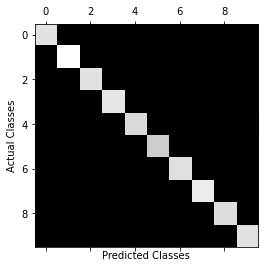

In [192]:
plt.clf()   # clear figure
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_plot_mnist", tight_layout=False)
plt.show()

In [193]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

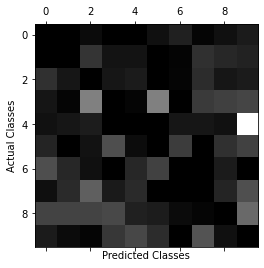

In [194]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_errors_plot_mnist_val", tight_layout=False)
plt.show()




## Experiment 7

- 28x28 images (784 pixels) reduced to 87 input nodes via PCA (n_components=0.90)
- hidden layer: 128 nodes
- output layer: 10 nodes

In [209]:
pca2 = PCA(n_components=0.90)
train_images_red2 = pca2.fit_transform(train_images)
val_images_red2 = pca2.transform(val_images)
test_images_red2 = pca2.transform(test_images)

In [210]:
test_images_red2.shape, train_images_red2.shape, val_images_red2.shape

((10000, 87), (55000, 87), (5000, 87))

In [211]:
pca2.n_components_

87

In [212]:
# k.clear_session()
model = Sequential([
    Dense(name = 'hidden_layer_1', units=128, activation='relu', input_shape=[87]),
    Dense(name = 'output_layer', units = 10, activation ='softmax')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               11264     
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 12,554
Trainable params: 12,554
Non-trainable params: 0
_________________________________________________________________


- given the past models we can confidently find best performing model within 10 epochs as val_loss starts increasing and leading the model to overfit to the training data

In [213]:
model.compile(optimizer='rmsprop',
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

history = model.fit(train_images_red2
    , train_labels
    , epochs=10
    , validation_data=(val_images_red2, val_labels)
    , callbacks=[tf.keras.callbacks.ModelCheckpoint("exp_8_optimized.h5",save_best_only=True,save_weights_only=False)] 
    )

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3131 - accuracy: 0.9125 - val_loss: 0.1465 - val_accuracy: 0.9608
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.1258 - accuracy: 0.9634 - val_loss: 0.1062 - val_accuracy: 0.9718
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0880 - accuracy: 0.9746 - val_loss: 0.0933 - val_accuracy: 0.9736
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0676 - accuracy: 0.9808 - val_loss: 0.0825 - val_accuracy: 0.9764
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0552 - accuracy: 0.9842 - val_loss: 0.0808 - val_accuracy: 0.9768
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0461 - accuracy: 0.9870 - val_loss: 0.0786 - val_accuracy: 0.9788
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0387 - accuracy: 0.9890 - val_loss: 0.0788 - val_accur

In [214]:
model = tf.keras.models.load_model("exp_8_optimized.h5")
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               11264     
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 12,554
Trainable params: 12,554
Non-trainable params: 0
_________________________________________________________________


In [215]:
test_loss, test_acc = model.evaluate(test_images_red2, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 1s 3ms/step - loss: 0.0740 - accuracy: 0.9780
test acc: 0.9779999852180481, test loss: 0.07398591935634613


In [216]:
history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

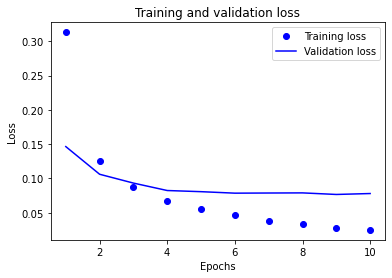

In [217]:
plt.clf()   # clear figure
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

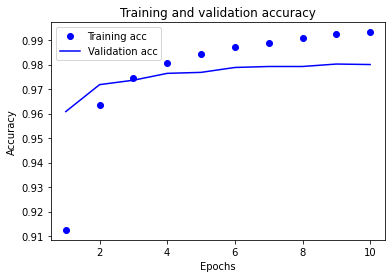

In [218]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [219]:
# Get the predicted classes:
# model.predict_classes() is depricated in TensorFlow 2.7+
# pred_classes = model.predict(train_images)
# alternate method:
pred_train=model.predict(train_images_red2) 
pred_classes=np.argmax(pred_train, axis=1)

1719/1719 [==============================] - 2s 1ms/step


In [220]:
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[5426,    0,    4,    0,    1,    0,    7,    2,    2,    2],
       [   0, 6154,    7,    1,    3,    0,    2,    9,    2,    1],
       [   2,    2, 5444,    2,    5,    0,    1,   11,    1,    2],
       [   0,    0,   11, 5588,    0,   13,    1,    9,    9,    7],
       [   0,    1,    1,    0, 5292,    0,    2,    2,    1,    8],
       [   2,    0,    1,   10,    1, 4957,    5,    0,    7,    4],
       [   2,    0,    1,    0,    1,    1, 5409,    0,    3,    0],
       [   1,    4,    9,    0,    7,    0,    0, 5688,    1,    5],
       [   1,    5,    3,    7,    3,    3,    2,    1, 5358,    6],
       [   3,    1,    1,    4,    7,    3,    1,   11,    2, 5421]],
      dtype=int64)

<Figure size 432x288 with 0 Axes>

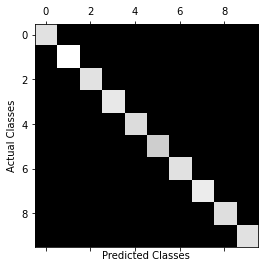

In [221]:
plt.clf()   # clear figure
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_plot_mnist", tight_layout=False)
plt.show()

In [222]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

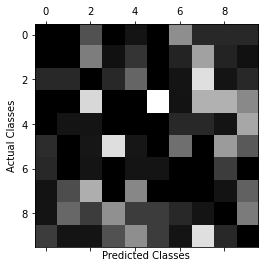

In [223]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_errors_plot_mnist_val", tight_layout=False)
plt.show()

## Experiment 8

- 28x28 images (784 pixels) reduced to 87 input nodes via PCA (n_components=0.90)
- hidden layer: 512 nodes
- output layer: 10 nodes

In [266]:
test_images_red2.shape, train_images_red2.shape, val_images_red2.shape

((10000, 87), (55000, 87), (5000, 87))

In [267]:
pca2.n_components_

87

In [268]:
# k.clear_session()
model = Sequential([
    Dense(name = 'hidden_layer_1', units=512, activation='relu', input_shape=[87]),
    Dense(name = 'output_layer', units = 10, activation ='softmax')
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 512)               45056     
                                                                 
 output_layer (Dense)        (None, 10)                5130      
                                                                 
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
_________________________________________________________________


In [269]:
model.compile(optimizer='rmsprop',
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

history = model.fit(train_images_red2
    , train_labels
    , epochs=10
    , validation_data=(val_images_red2, val_labels)
    , callbacks=[tf.keras.callbacks.ModelCheckpoint("exp_12_optimized.h5",save_best_only=True,save_weights_only=False)] 
    )

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2147 - accuracy: 0.9404 - val_loss: 0.1001 - val_accuracy: 0.9724
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0799 - accuracy: 0.9767 - val_loss: 0.0724 - val_accuracy: 0.9816
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0508 - accuracy: 0.9848 - val_loss: 0.0720 - val_accuracy: 0.9806
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0350 - accuracy: 0.9897 - val_loss: 0.0619 - val_accuracy: 0.9846
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0250 - accuracy: 0.9931 - val_loss: 0.0687 - val_accuracy: 0.9836
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0177 - accuracy: 0.9952 - val_loss: 0.0685 - val_accuracy: 0.9826
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0123 - accuracy: 0.9966 - val_loss: 0.0767 - val_accuracy:

In [270]:
model = tf.keras.models.load_model("exp_12_optimized.h5")
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 512)               45056     
                                                                 
 output_layer (Dense)        (None, 10)                5130      
                                                                 
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0
_________________________________________________________________


In [271]:
test_loss, test_acc = model.evaluate(test_images_red2, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 1s 3ms/step - loss: 0.0626 - accuracy: 0.9823
test acc: 0.9822999835014343, test loss: 0.06259778887033463


In [272]:
history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

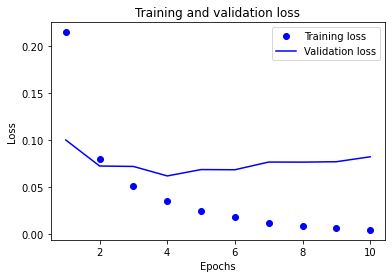

In [273]:
plt.clf()   # clear figure
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

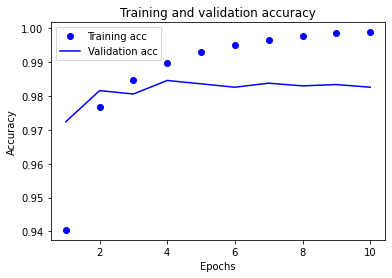

In [274]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [275]:
# Get the predicted classes:
# model.predict_classes() is depricated in TensorFlow 2.7+
# pred_classes = model.predict(train_images)
# alternate method:
pred_train=model.predict(train_images_red2) 
pred_classes=np.argmax(pred_train, axis=1)

1719/1719 [==============================] - 2s 1ms/step


In [276]:
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[5429,    0,    7,    0,    0,    1,    3,    0,    1,    3],
       [   0, 6159,    6,    0,    2,    0,    0,   10,    1,    1],
       [   5,    2, 5441,    3,    2,    0,    0,   10,    3,    4],
       [   0,    0,   14, 5591,    0,   14,    0,    9,    8,    2],
       [   0,    5,    1,    0, 5264,    1,    2,    5,    4,   25],
       [   1,    0,    1,    4,    0, 4971,    4,    1,    2,    3],
       [   3,    3,    0,    0,    3,    6, 5400,    0,    2,    0],
       [   1,    3,   10,    0,    3,    0,    0, 5693,    3,    2],
       [   3,   11,    2,    7,    2,    3,    1,    1, 5352,    7],
       [   4,    1,    0,    3,    7,    3,    0,   16,    2, 5418]],
      dtype=int64)

<Figure size 432x288 with 0 Axes>

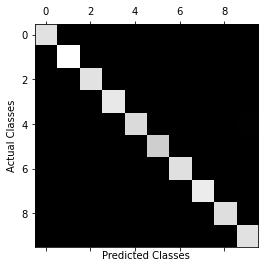

In [277]:
plt.clf()   # clear figure
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_plot_mnist", tight_layout=False)
plt.show()

In [278]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

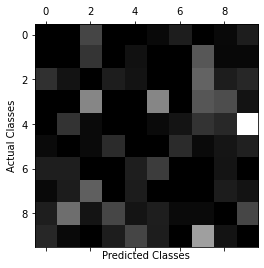

In [279]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_errors_plot_mnist_val", tight_layout=False)
plt.show()

In [280]:
pca2 = PCA(n_components=0.90)
train_images_red2 = pca2.fit_transform(train_images)
val_images_red2 = pca2.transform(val_images)
test_images_red2 = pca2.transform(test_images)

## Experiment 9

- 28x28 images (784 pixels) reduced to 87 input nodes via PCA (n_components=0.85)
- hidden layer: 512 nodes
- output layer: 10 nodes

In [281]:
pca3 = PCA(n_components=0.85)
train_images_red3 = pca3.fit_transform(train_images)
val_images_red3 = pca3.transform(val_images)
test_images_red3 = pca3.transform(test_images)

In [282]:
test_images_red3.shape, train_images_red3.shape, val_images_red3.shape

((10000, 59), (55000, 59), (5000, 59))

In [283]:
pca3.n_components_

59

In [284]:
# k.clear_session()
model = Sequential([
    Dense(name = 'hidden_layer_1', units=512, activation='relu', input_shape=[59]),
    Dense(name = 'output_layer', units = 10, activation ='softmax')
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 512)               30720     
                                                                 
 output_layer (Dense)        (None, 10)                5130      
                                                                 
Total params: 35,850
Trainable params: 35,850
Non-trainable params: 0
_________________________________________________________________


In [285]:
model.compile(optimizer='rmsprop',
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

history = model.fit(train_images_red3
    , train_labels
    , epochs=10
    , validation_data=(val_images_red3, val_labels)
    , callbacks=[tf.keras.callbacks.ModelCheckpoint("exp_13_optimized.h5",save_best_only=True,save_weights_only=False)] 
    )

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2154 - accuracy: 0.9411 - val_loss: 0.1033 - val_accuracy: 0.9718
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0843 - accuracy: 0.9750 - val_loss: 0.0724 - val_accuracy: 0.9804
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0572 - accuracy: 0.9831 - val_loss: 0.0678 - val_accuracy: 0.9812
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0427 - accuracy: 0.9879 - val_loss: 0.0617 - val_accuracy: 0.9834
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0327 - accuracy: 0.9905 - val_loss: 0.0663 - val_accuracy: 0.9828
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0261 - accuracy: 0.9921 - val_loss: 0.0643 - val_accuracy: 0.9844
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0202 - accuracy: 0.9944 - val_loss: 0.0693 - val_accuracy:

In [286]:
model = tf.keras.models.load_model("exp_13_optimized.h5")
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 512)               30720     
                                                                 
 output_layer (Dense)        (None, 10)                5130      
                                                                 
Total params: 35,850
Trainable params: 35,850
Non-trainable params: 0
_________________________________________________________________


In [287]:
test_loss, test_acc = model.evaluate(test_images_red3, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 1s 3ms/step - loss: 0.0661 - accuracy: 0.9813
test acc: 0.9812999963760376, test loss: 0.06613625586032867


In [288]:
history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

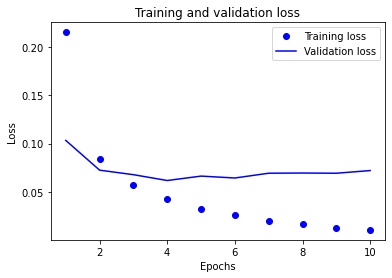

In [289]:
plt.clf()   # clear figure
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

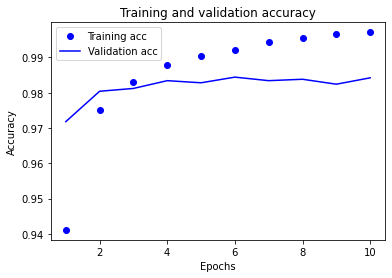

In [290]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [291]:
# Get the predicted classes:
# model.predict_classes() is depricated in TensorFlow 2.7+
# pred_classes = model.predict(train_images)
# alternate method:
pred_train=model.predict(train_images_red3) 
pred_classes=np.argmax(pred_train, axis=1)

1719/1719 [==============================] - 2s 1ms/step


In [292]:
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[5426,    0,    5,    0,    1,    1,    4,    1,    3,    3],
       [   0, 6153,    8,    0,    2,    0,    0,    9,    3,    4],
       [   8,    5, 5427,    3,    1,    1,    1,   16,    4,    4],
       [   0,    2,   16, 5580,    0,   17,    0,    6,   12,    5],
       [   0,    6,    2,    1, 5252,    1,    5,    5,    4,   31],
       [   3,    0,    2,    6,    0, 4960,    4,    1,    5,    6],
       [   6,    5,    2,    1,    2,   10, 5386,    0,    5,    0],
       [   4,    5,   12,    1,    4,    2,    0, 5672,    5,   10],
       [   5,   10,    6,   11,    2,    8,    0,    2, 5333,   12],
       [   4,    2,    2,    5,   10,    9,    0,   15,    1, 5406]],
      dtype=int64)

<Figure size 432x288 with 0 Axes>

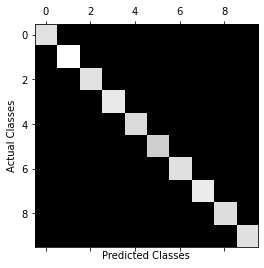

In [293]:
plt.clf()   # clear figure
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_plot_mnist", tight_layout=False)
plt.show()

In [294]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

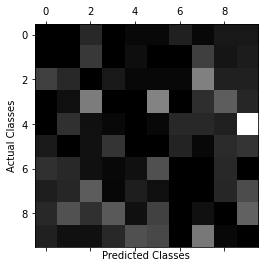

In [295]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_errors_plot_mnist_val", tight_layout=False)
plt.show()

In [296]:
pca2 = PCA(n_components=0.90)
train_images_red2 = pca2.fit_transform(train_images)
val_images_red2 = pca2.transform(val_images)
test_images_red2 = pca2.transform(test_images)

## Experiment 10

- 28x28 images (784 pixels) reduced to 87 input nodes via PCA (n_components=0.90)
- hidden layer: 1024 nodes
- output layer: 10 nodes

In [297]:
test_images_red2.shape, train_images_red2.shape, val_images_red2.shape

((10000, 87), (55000, 87), (5000, 87))

In [298]:
pca2.n_components_

87

In [299]:
# k.clear_session()
model = Sequential([
    Dense(name = 'hidden_layer_1', units=1024, activation='relu', input_shape=[87]),
    Dense(name = 'output_layer', units = 10, activation ='softmax')
])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 1024)              90112     
                                                                 
 output_layer (Dense)        (None, 10)                10250     
                                                                 
Total params: 100,362
Trainable params: 100,362
Non-trainable params: 0
_________________________________________________________________


In [300]:
model.compile(optimizer='rmsprop',
               loss = 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

history = model.fit(train_images_red2
    , train_labels
    , epochs=10
    , validation_data=(val_images_red2, val_labels)
    , callbacks=[tf.keras.callbacks.ModelCheckpoint("exp_14_optimized.h5",save_best_only=True,save_weights_only=False)] 
    )

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.1858 - accuracy: 0.9477 - val_loss: 0.0886 - val_accuracy: 0.9758
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0698 - accuracy: 0.9794 - val_loss: 0.0731 - val_accuracy: 0.9822
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0435 - accuracy: 0.9872 - val_loss: 0.0724 - val_accuracy: 0.9826
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0287 - accuracy: 0.9916 - val_loss: 0.0677 - val_accuracy: 0.9824
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0195 - accuracy: 0.9944 - val_loss: 0.0744 - val_accuracy: 0.9826
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0134 - accuracy: 0.9959 - val_loss: 0.0730 - val_accuracy: 0.9834
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0083 - accuracy: 0.9977 - val_loss: 0.0864 - val_accuracy

In [301]:
model = tf.keras.models.load_model("exp_14_optimized.h5")
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 1024)              90112     
                                                                 
 output_layer (Dense)        (None, 10)                10250     
                                                                 
Total params: 100,362
Trainable params: 100,362
Non-trainable params: 0
_________________________________________________________________


In [302]:
test_loss, test_acc = model.evaluate(test_images_red2, test_labels)
print(f'test acc: {test_acc}, test loss: {test_loss}')

313/313 [==============================] - 1s 2ms/step - loss: 0.0681 - accuracy: 0.9808
test acc: 0.9807999730110168, test loss: 0.06812109053134918


In [303]:
history_dict = history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

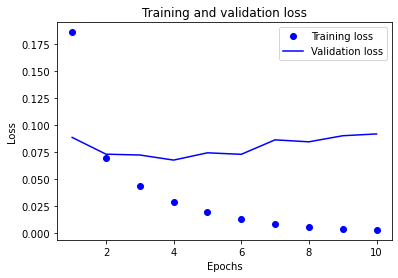

In [304]:
plt.clf()   # clear figure
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

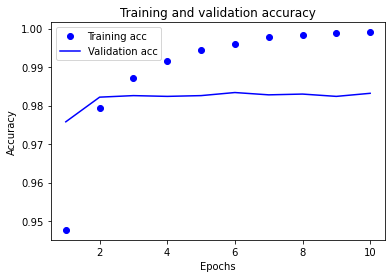

In [305]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [306]:
# Get the predicted classes:
# model.predict_classes() is depricated in TensorFlow 2.7+
# pred_classes = model.predict(train_images)
# alternate method:
pred_train=model.predict(train_images_red2) 
pred_classes=np.argmax(pred_train, axis=1)

1719/1719 [==============================] - 2s 1ms/step


In [307]:
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[5436,    0,    3,    0,    0,    0,    2,    0,    2,    1],
       [   0, 6162,    6,    0,    1,    0,    1,    6,    1,    2],
       [   3,    3, 5448,    2,    1,    0,    1,    8,    1,    3],
       [   0,    1,    6, 5618,    0,    6,    0,    3,    1,    3],
       [   0,    3,    2,    0, 5254,    1,    3,    4,    2,   38],
       [   1,    0,    0,    3,    0, 4972,    2,    0,    2,    7],
       [   1,    0,    0,    0,    1,    5, 5406,    0,    4,    0],
       [   2,    3,    5,    0,    0,    0,    0, 5698,    2,    5],
       [   2,    7,    8,    7,    0,    3,    0,    0, 5353,    9],
       [   1,    1,    0,    0,    6,    2,    0,    7,    1, 5436]],
      dtype=int64)

<Figure size 432x288 with 0 Axes>

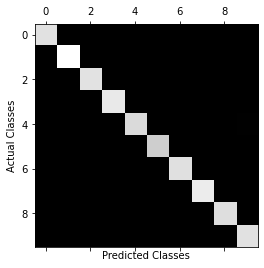

In [308]:
plt.clf()   # clear figure
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_plot_mnist", tight_layout=False)
plt.show()

In [309]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

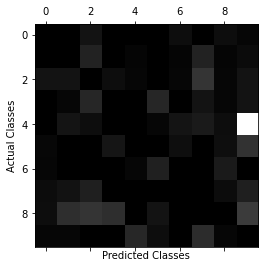

In [310]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
#plt.savefig("confusion_matrix_errors_plot_mnist_val", tight_layout=False)
plt.show()

In [311]:
pca2 = PCA(n_components=0.90)
train_images_red2 = pca2.fit_transform(train_images)
val_images_red2 = pca2.transform(val_images)
test_images_red2 = pca2.transform(test_images)

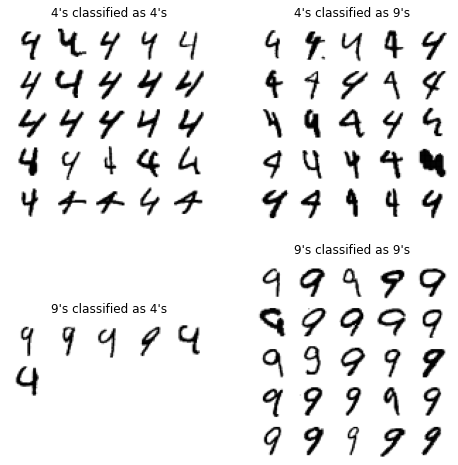

In [312]:
cl_a, cl_b = 4, 9
X_aa = train_images[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(8,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()